# Computational Musicology Project
## Analysis of Turkish Makam Music

Turkish makams can be defined by their musical scale, in that every makam is composed of a certain set of notes. Although variations of notes can be played in a makam in performance, the usual notes that appear in a piece will be those in the makam's scale.

For example, in the makam Hicaz, we will find the following notes: Dugah, Dik Kurdi, Nim Hicaz, Neva, Huseyni, Evic, Gerdaniye, and Muhayyer. This scale is illustrated below:

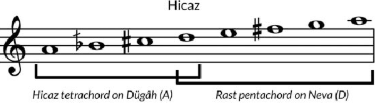

Within this set of notes, each makam will have a tonic note, a dominant note, and sometimes a subdominant note or suspended cadences. This is following the structure of Western music notations and having tonic notes in every scale. The suspended cadences will often use cesni, or 'flavours' of notes as modulations to the preset scale. For the purpose of this notebook, we will not explore the effects of cesni in the results. 

In the case of the makam Hicaz, the tonic note is Dugah, the dominant note is Neva, and the suspended cadences are Nim Hicaz and Dik Kurdi. 

Turkish traditional music is also very focused on rhythm, and uses usuls to structure the rhythm of a piece. An usul is a sequence of beats with varying accents, expressed as a time signature. Usul beats are referred to by 'dum', 'tek', or 'ke' to emulate the sound produced by the drum. 'Dum' beats are produced by hitting the center of the drum with the left hand, producing a strong sound, and 'tek' beats are more on the outside of the drum with the right hand, producing a lighter sound. 

The following is an illustration of the beats in the usul aksak:

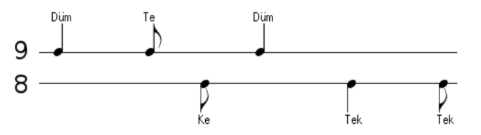

The usul aksak can be expressed as a time signature 9/8, with each measure consisting of nine beats, and each beat consisting of an eighth note.

Songs of the Turkish makam variety are described and categorized by their makam and usul. Scores of makam music will annotate the makam and usul underneath the song title. Certain makams and usuls are more prevalent and popular in makam music, and there are certain makam-usul combinations that appear more frequently than others in songs.

### Research Question:
Is there a relation between the importance of a note within a makam and its beat position in the usul?

### Methodology:
Determine the top 10 combinations of makam and usuls in the database. 
Determine the most common makam notes that occur on the beats of the respective usul.
Plot a histogram that shows the occurrence of makam notes at each beat position of the usul. The histogram will contain the top three note names for each usul beat.

First, we declare some functions to handle the scores, we also have a file named "mu_Info.py", that should be in this same folder, containing information about the makams and usuls.

In [1]:
import os

import xml.etree.ElementTree as ET
from music21 import *
from mu_Info import *

import matplotlib.pyplot as plt
import numpy as np

# Remove the key signature from the selected file
def clean_xml(root, file, output_folder):
    if not output_folder.endswith('/'):
        output_folder += '/'
    tree = ET.parse(root+'/'+file)
    root = tree.getroot()

    for k in root.iter('key'):
        for ks in k.findall('key-step'):
            k.remove(ks)
        for ka in k.findall('key-accidental'):
            k.remove(ka)
        for ka in k.findall('key-alter'):
            k.remove(ka)

    n_file = output_folder + file[:-4] + 'noKeySig.xml'
    tree.write(n_file)
    return n_file

# Open the xml with music21 and get the parts, also catch any problematic file and show it in the console to further review
def get_parts(file):
    try:
        s = converter.parse(file)
        pp = s.parts
    except:
        print('review this file:', file)
        pp = list()
    return pp

# This code will get a part from a score, retrieve all the notes with their offsets, and then compare to the beat positions of the usul
def get_notes_on_beat(p, usul, beat_dict):
    nn = p.flat.notes.stream()
    m0 = p.getElementsByClass(stream.Measure).stream()[0]
    tS = m0.getElementsByClass(meter.TimeSignature).stream()[0]
    m_length = tS.numerator*(4/tS.denominator)
    beat_name = [a[0]+'_{}'.format(a[1]) for a in usul]
    beats = [a[1] for a in usul]
    for n in nn:
        beat_pos = 2*(n.offset % m_length) + 1
        if beat_pos in beats:
            n_pitch_name = n.fullName.split()[0]+n.fullName.split()[3]
            note_name = ALL_NOTES.get(n_pitch_name, n_pitch_name)
            beat_tag = beat_name[beats.index(beat_pos)]
            beat_dict[beat_tag] = beat_dict.get(beat_tag, dict())
            beat_dict[beat_tag][note_name] = beat_dict[beat_tag].get(note_name, 0) + 1
    return beat_dict

### Counting makam-usul combinations
The first step is to parse the database and determine how many different combinations of makams and usuls are found in the .xml files.
IMPORTANT: In the same folder of this notebook, should be the "SymbTr-2.0.0" database.

In [2]:
# Look at the filenames within this directory
makamUsul_dict = dict()
print('Reading data ...')
print('Looking for makam-usul combinations')

for root, dirs, files in os.walk('./SymbTr-2.0.0'):
    for file in files:
        # skip non ".xml" files
        if '.xml' not in file:
            continue
        sfile = file.split('--')
        # skip not correctly formatted file names
        if len(sfile) < 3:
            continue
        # count the occurrences of every combinations of makam-usul
        mu_key = sfile[0]+'--'+sfile[2]
        makamUsul_dict[mu_key] = makamUsul_dict.get(mu_key,0) + 1
        
print(len(makamUsul_dict), 'different combinations of makam-usul found')

Reading data ...
Looking for makam-usul combinations
870 different combinations of makam-usul found


### Filtering the top 10 makam-usul combinations
Next, the ten makam-usul combinations with the most attributed scores will be selected, so as not to analyze makam-usul combinations that are not commonly used in Turkish Makam music.  

In [3]:
mu_top = sorted(makamUsul_dict, key = makamUsul_dict.get, reverse = True)[0:10]
print('\nTop 10 combinations:')
_ = [print(mu) for mu in mu_top]


Top 10 combinations:
hicaz--aksak
nihavent--duyek
huzzam--aksak
hicaz--sofyan
ussak--sofyan
hicaz--duyek
ussak--aksak
segah--aksak
rast--duyek
mahur--aksak


### Score analysis
We can then create a dictionary containing all the scores from the top 10 makam-usul combinations that are to be analyzed.

In order to be processed by music21, the key signature needs to be removed from the .xml files for these scores. This is done by the clean_xml function declared before. The resulting xml files will be saved in the "selected_scores" folder

In [4]:
print('\nSelecting the files with the desired makam-usul combination')
print('Removing key signatures out of the xml file')
f_dict = dict()

for root, dirs, files in os.walk('./SymbTr-2.0.0'):
    for file in files:
        # skip non ".xml" files
        if '.xml' not in file:
            continue
        sfile = file.split('--')
        # skip not correctly formated file names
        if len(sfile) < 3:
            continue
        mu_key = mu_key = sfile[0]+'--'+sfile[2]
        if mu_key in mu_top:
            f_xml = clean_xml(root, file, './selected_scores/')
            f_dict[f_xml] = {'group': mu_key, 'makam': sfile[0], 'usul': sfile[2]}

print(len(f_dict), 'scores will be computed')


Selecting the files with the desired makam-usul combination
Removing key signatures out of the xml file
209 scores will be computed


For each score, the number of makam notes that occur on the usul beats will be tallied and classified per makam note name. 

In [5]:
print('Starting the score analysis ...')
beat_dict = dict()

for file, values in f_dict.items():
    # beat_dict contains the whole structure
    # the first level are dictionaries by combination
    beat_dict[values['group']] = beat_dict.get(values['group'], dict())
    pp = get_parts(file)
    usul = USUL[values['usul']]
    for p in pp:
        beat_dict[values['group']] = get_notes_on_beat(p, usul, beat_dict[values['group']])

print('Score analysis: DONE')

Starting the score analysis ...
review this file: ./selected_scores/huzzam--sarki--aksak--vefa_yoktur--tanburi_mustafa_cavusnoKeySig.xml
review this file: ./selected_scores/hicaz--turku--sofyan--ela_gozlerine--sadettin_kaynaknoKeySig.xml
review this file: ./selected_scores/huzzam--sarki--aksak--gonul_verdim--iii_selimnoKeySig.xml
review this file: ./selected_scores/hicaz--turku--aksak--karanfil_oylum_oylum--noKeySig.xml
review this file: ./selected_scores/hicaz--sarki--sofyan--ada_sahillerinde--noKeySig.xml
Score analysis: DONE


### Counting the occurrences of makam notes on usul beat positions
For each of the ten makam-usul combinations, we will print the three most common notes that occur on each of the usul beats.

In [6]:
top_dict = dict()

for mu in mu_top:
    top_dict[mu] = dict()
    makam = mu.split('--')[0]
    usul = USUL[mu.split('--')[1]]
    beat_name = [a[0]+'_{}'.format(a[1]) for a in usul]
    print('\nMost common notes of the makam {} on the usul`s beat {}:'.format(makam, mu.split('--')[1]))
    for beat in beat_name:
        top_notes = sorted(beat_dict[mu][beat], key = beat_dict[mu][beat].get, reverse = True)[0:3]
        top_dict[mu][beat] = [(note, beat_dict[mu][beat][note]) for note in top_notes]
        print(beat, top_dict[mu][beat])
    print(makam, 'notes:')
    print(MAKAM[makam])



Most common notes of the makam hicaz on the usul`s beat aksak:
dum_1 [('Neva', 211), ('Huseyni', 191), ('Kaba Dugah', 144)]
te_3 [('Huseyni', 202), ('Nim Hicaz', 147), ('Neva', 130)]
ke_4 [('Neva', 194), ('Huseyni', 155), ('Acem', 119)]
dum_5 [('Huseyni', 242), ('Nim Hicaz', 191), ('Neva', 127)]
tek_7 [('Huseyni', 207), ('Kaba Dugah', 185), ('Nim Hicaz', 171)]
tek_9 [('Huseyni', 158), ('Neva', 137), ('Nim Hicaz', 116)]
hicaz notes:
['Dugah', 'Dik Kurdi', 'Nim Hicaz', 'Neva', 'Huseyni', 'Evic', 'Gerdaniye', 'Muhayyer']

Most common notes of the makam nihavent on the usul`s beat duyek:
dum_1 [('Neva', 320), ('Cargah', 139), ('Rast', 122)]
tek_2 [('Neva', 246), ('Gerdaniye', 171), ('Nim Hisar', 125)]
tek_4 [('Neva', 235), ('Kaba Kurdi', 148), ('Cargah', 138)]
dum_5 [('Neva', 270), ('Kaba Kurdi', 172), ('Cargah', 165)]
tek_7 [('Neva', 223), ('Kaba Kurdi', 133), ('Gerdaniye', 133)]
nihavent notes:
['Rast', 'Dugah', 'Kurdi', 'Cargah', 'Neva', 'Nim Hisar', 'Hisar', 'Acem', 'Evic', 'Gerdaniye

The results show that the most common note that occurs on the usul beats is usually the dominant note of the particular makam scale. For example, in the makam Segah, whose tonic is Segah and dominant note is Neva, the most common note occurring on every usul beat is the Neva.

An interesting result is that the tonic note of the makam scales is almost never in the top 3 most occurring makam notes. For instance, the tonic of the makam Mahur is Rast, and it does not occur in the top 3 notes on any of its usul beats. The same goes for the Segah note in the makam Segah. There are also instances where there are frequent occurrences of the tonic note transposed by an octave, like for the makam Ussak. The tonic Dugah never appears in the top 3, however the Kaba Dugah note occurs often on beats 1, 7, and 9. 

These results are curious; although it is to be expected that the dominant note appears often on the usul beats, the rarity of the tonic note is unexpected. Perhaps this is due to the use of suspended cadences. The suspended cadences of a makam occur often on the usul beats, as is shown in the results above. This may indicate that the tonic is played less often so as to heighten the satisfaction of returning to the final tonic at the end of a section or of the entire song. The deceptive cadence is often used in Western classical music as well. 

In [7]:
print("Whole list of notes occurrence")
for mu in mu_top:
    print()
    print(mu.upper())
    for bt in beat_dict[mu]:
        print()
        print(bt, beat_dict[mu][bt])
    print()

Whole list of notes occurrence

HICAZ--AKSAK

dum_1 {'Huseyni': 191, 'Neva': 211, 'Nim Hicaz': 134, 'Gerdaniye': 77, 'Kaba Dik Kurdi': 55, 'Kaba Dugah': 144, 'Rast': 22, 'Dugah': 63, 'Segah': 1, 'Evic': 24, 'Dik Kurdi': 4, 'Cargah': 6, 'Acem': 21, 'Kaba Segah': 3, 'Yegah': 1, 'Buselik': 4, 'Tiz Cargah': 2, 'Mahur': 2, 'Nim Hisar': 2, 'Nim Sehnaz': 5, 'Kaba Buselik': 2}

te_3 {'Acem': 55, 'Neva': 130, 'Kaba Dik Kurdi': 60, 'Gerdaniye': 110, 'Huseyni': 202, 'Nim Hicaz': 147, 'Irak': 14, 'Dugah': 53, 'Rast': 18, 'Kaba Segah': 5, 'Kaba Dugah': 69, 'Evic': 23, 'Cargah': 4, 'Yegah': 1, 'Buselik': 4, 'Tiz Cargah': 2, 'Nim Sehnaz': 1, 'Mahur': 4, 'Dik Kurdi': 1}

ke_4 {'Huseyni': 155, 'Neva': 194, 'Kaba Dik Kurdi': 93, 'Acem': 119, 'Rast': 22, 'Kaba Dugah': 69, 'Nim Hicaz': 82, 'Dugah': 53, 'Evic': 36, 'Segah': 3, 'Gerdaniye': 83, 'Cargah': 5, 'Buselik': 9, 'Irak': 4, 'Mahur': 7, 'Tiz Cargah': 1, 'Nim Sehnaz': 4, 'Kaba Buselik': 2, 'Dik Kurdi': 2, 'Tiz Nim Hicaz': 1}

dum_5 {'Nim Hicaz': 191, 

### Plotting a histogram
Using these makam note occurrences, we can now plot a histogram that shows the occurrences for each note at each beat position in the usul. The result will consist of 10 histograms, one for each makam-usul combination.

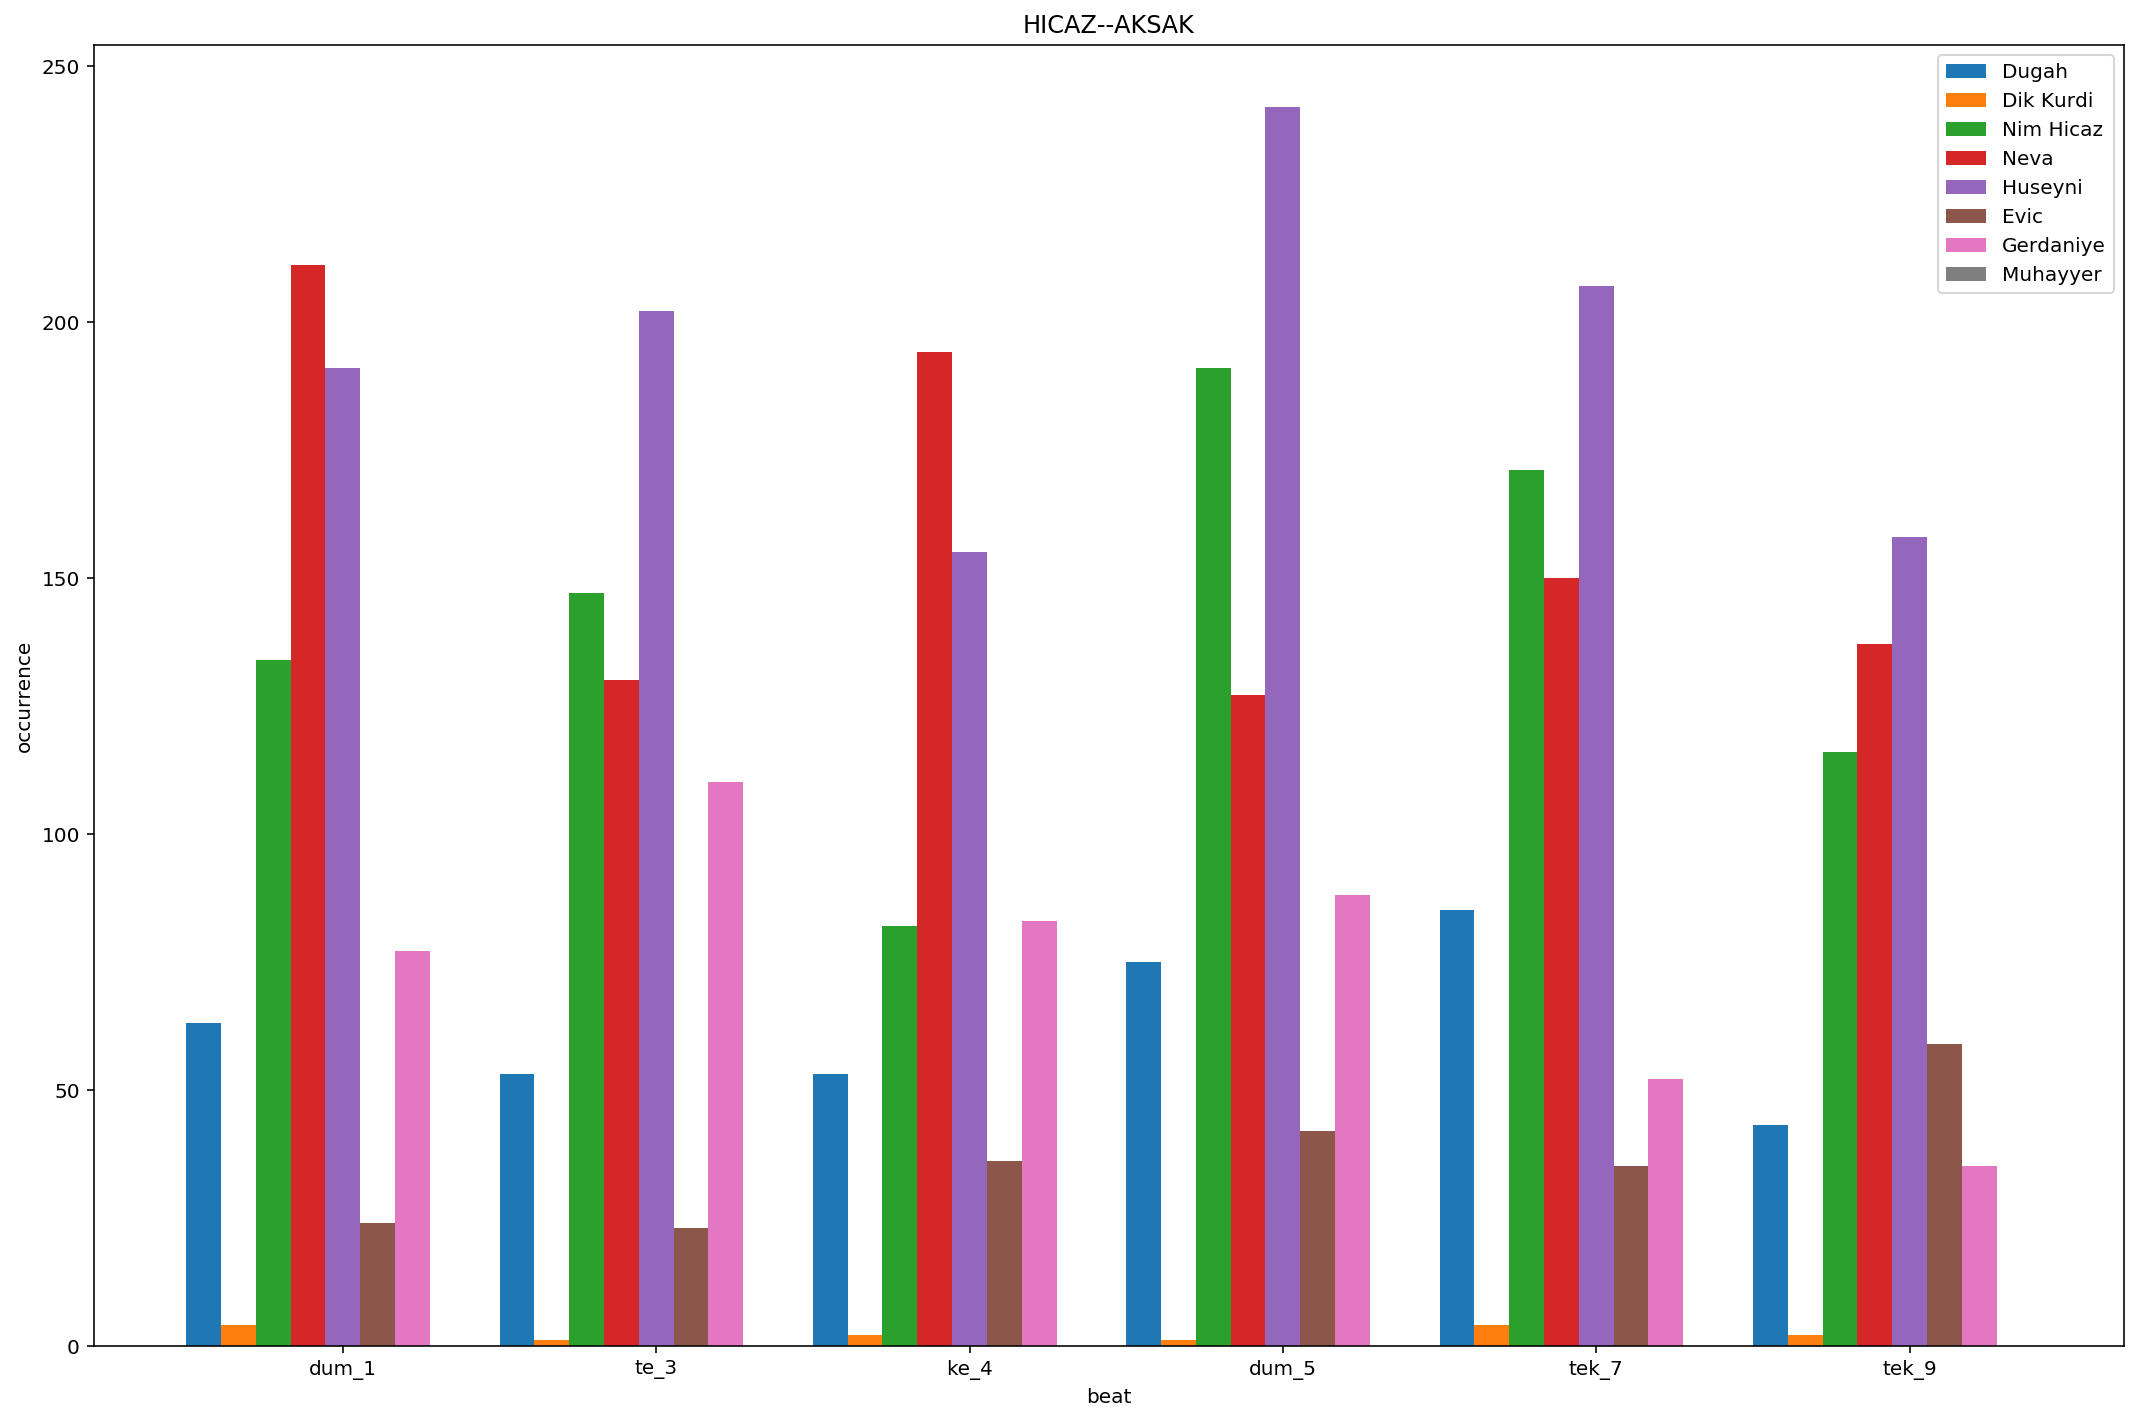

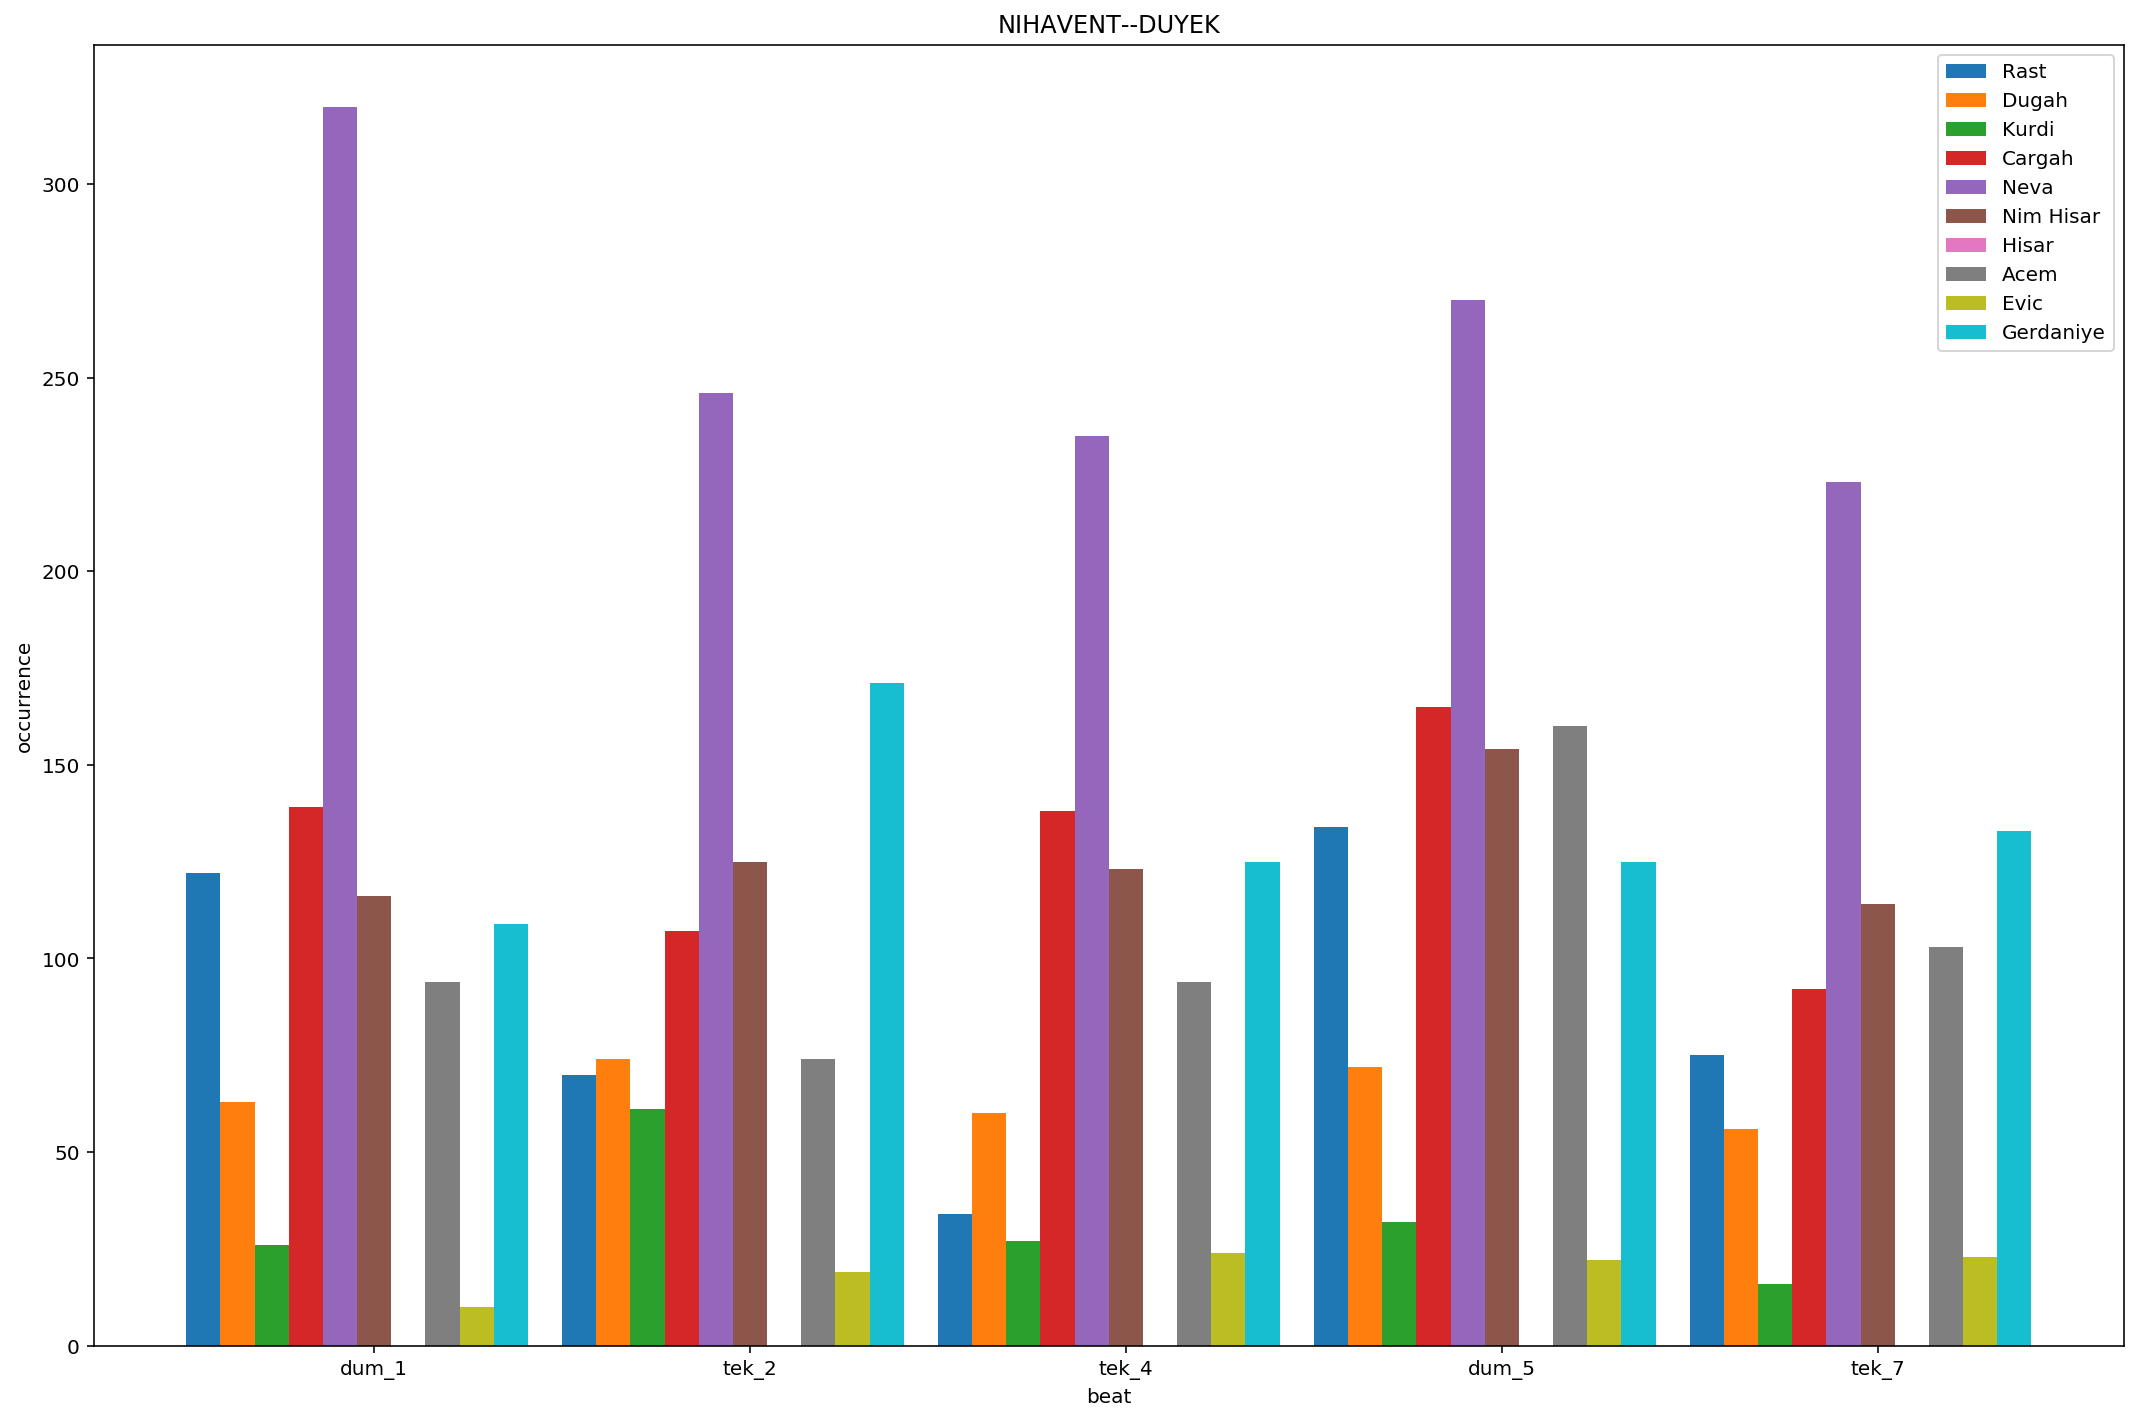

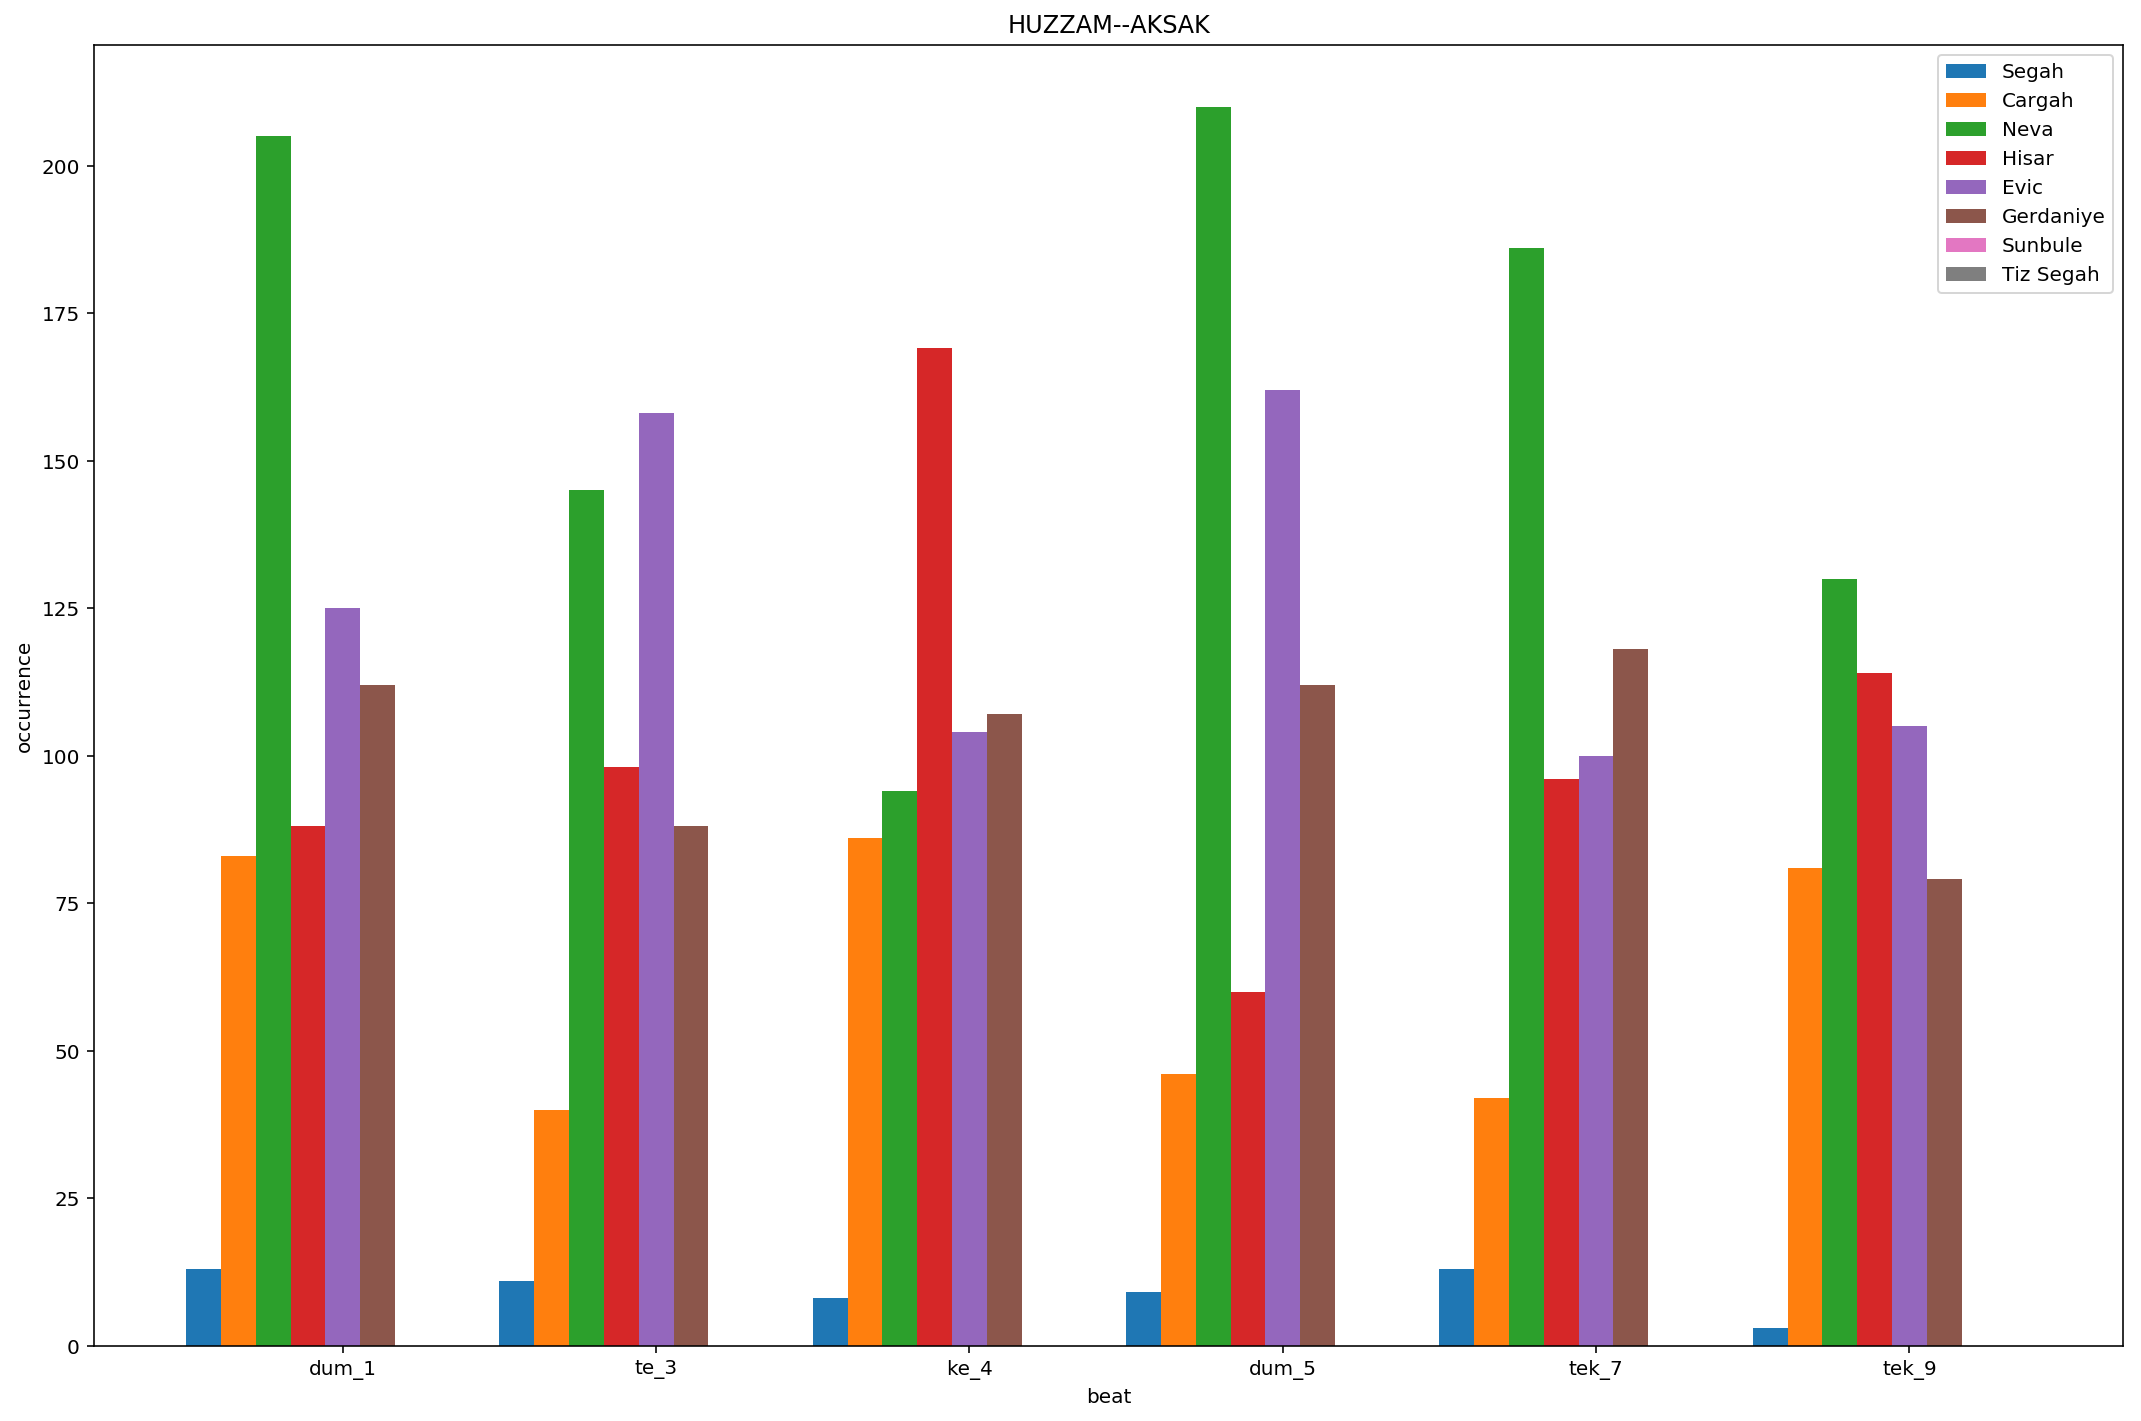

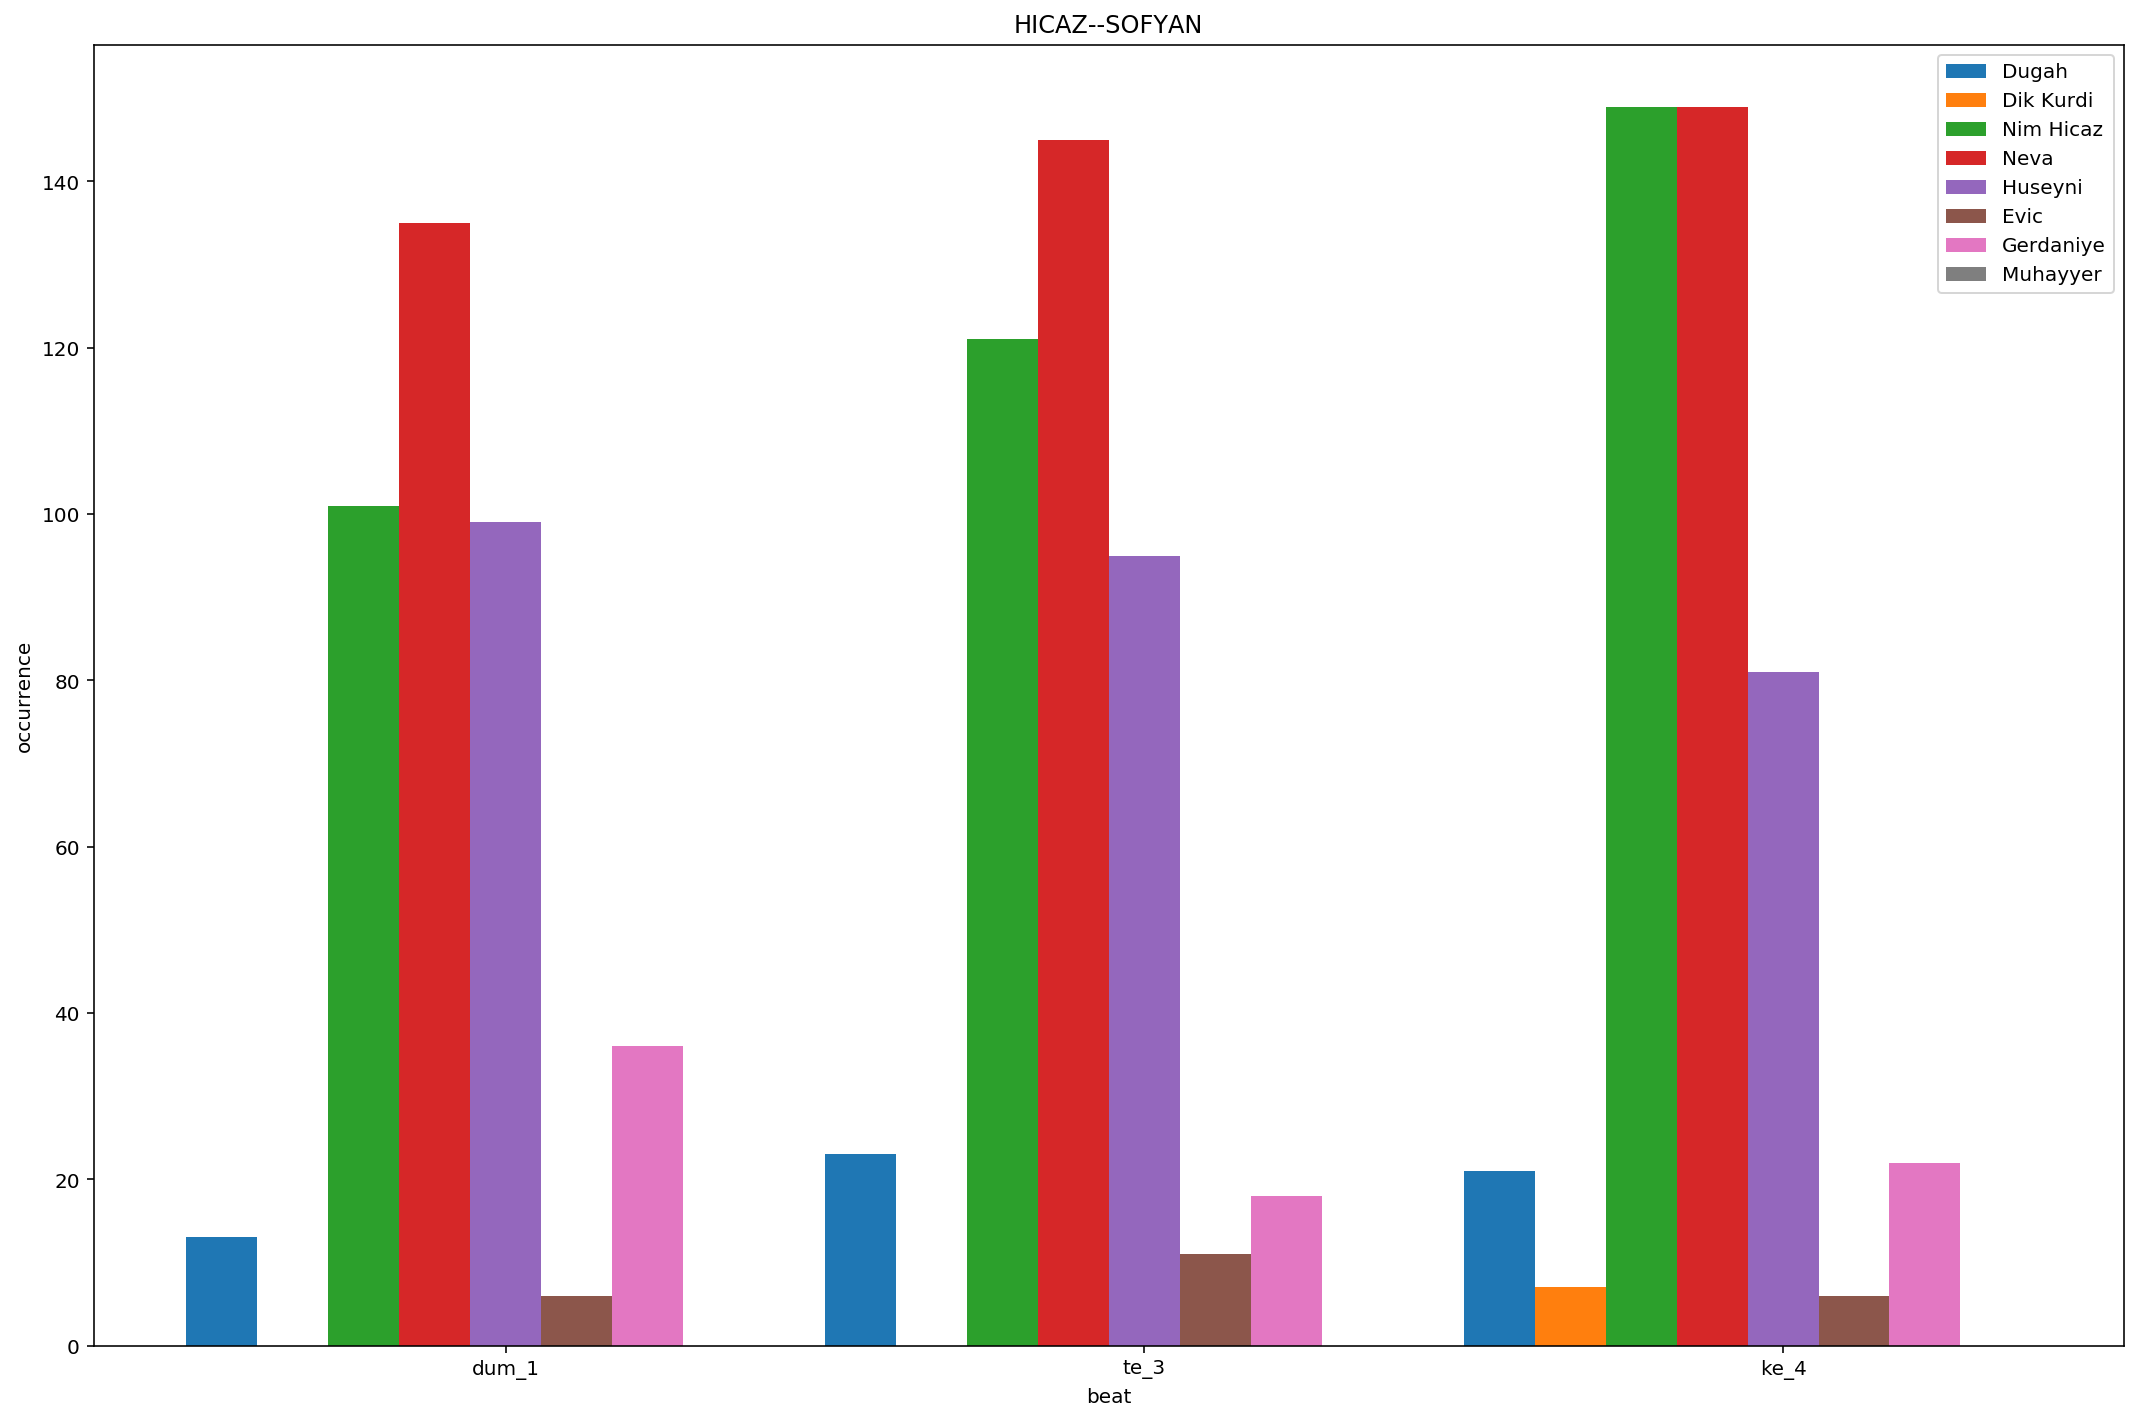

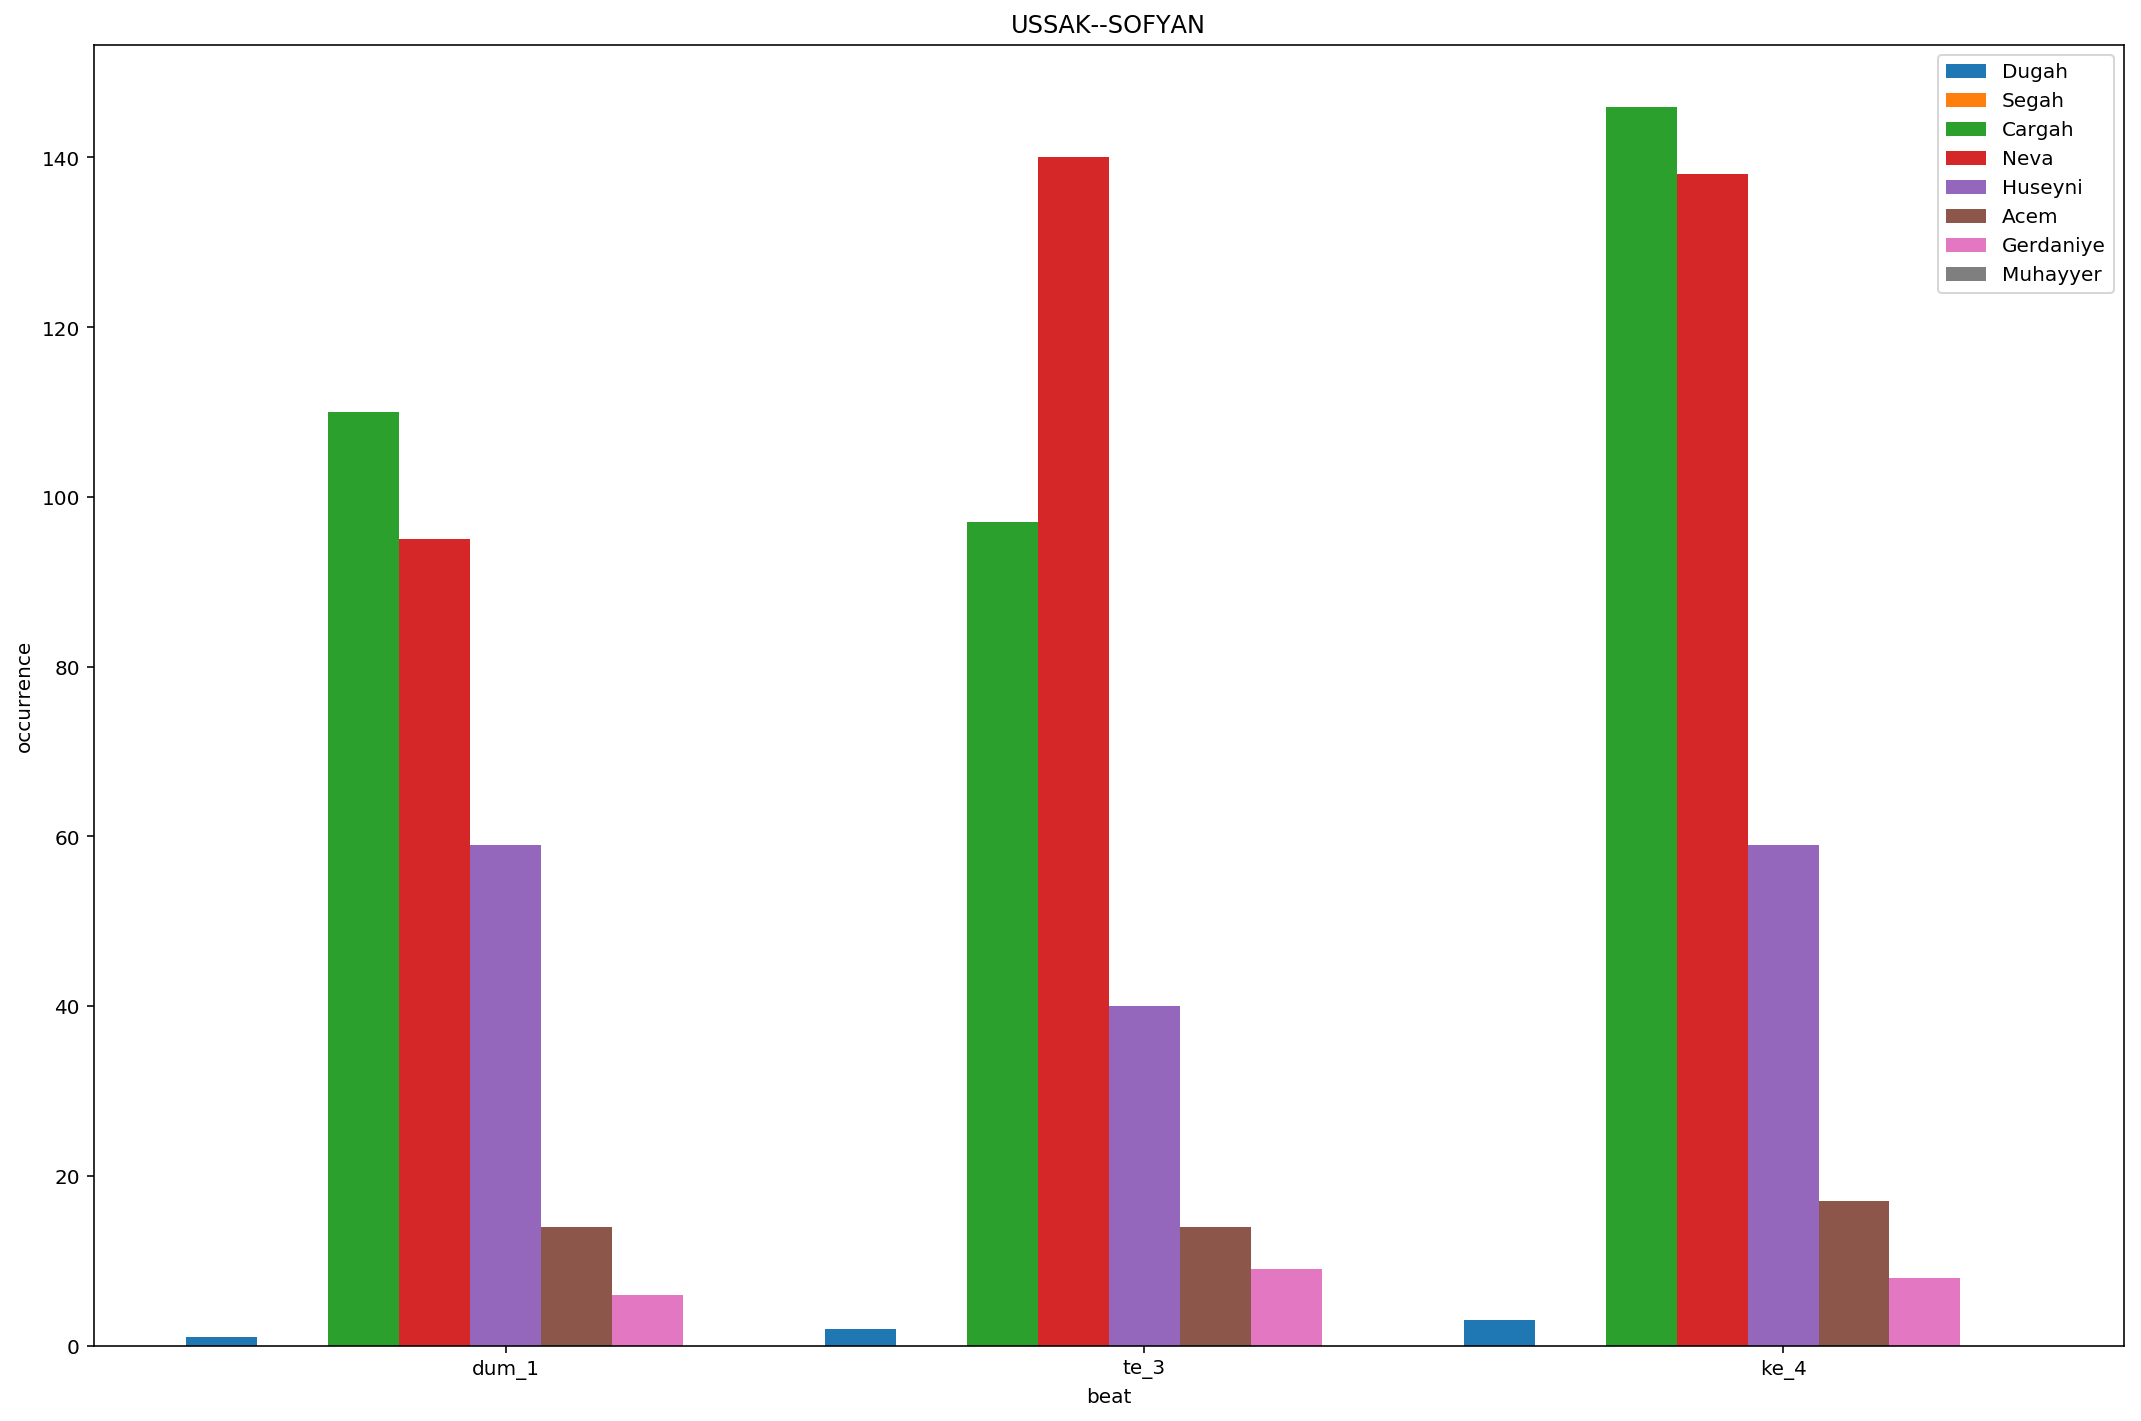

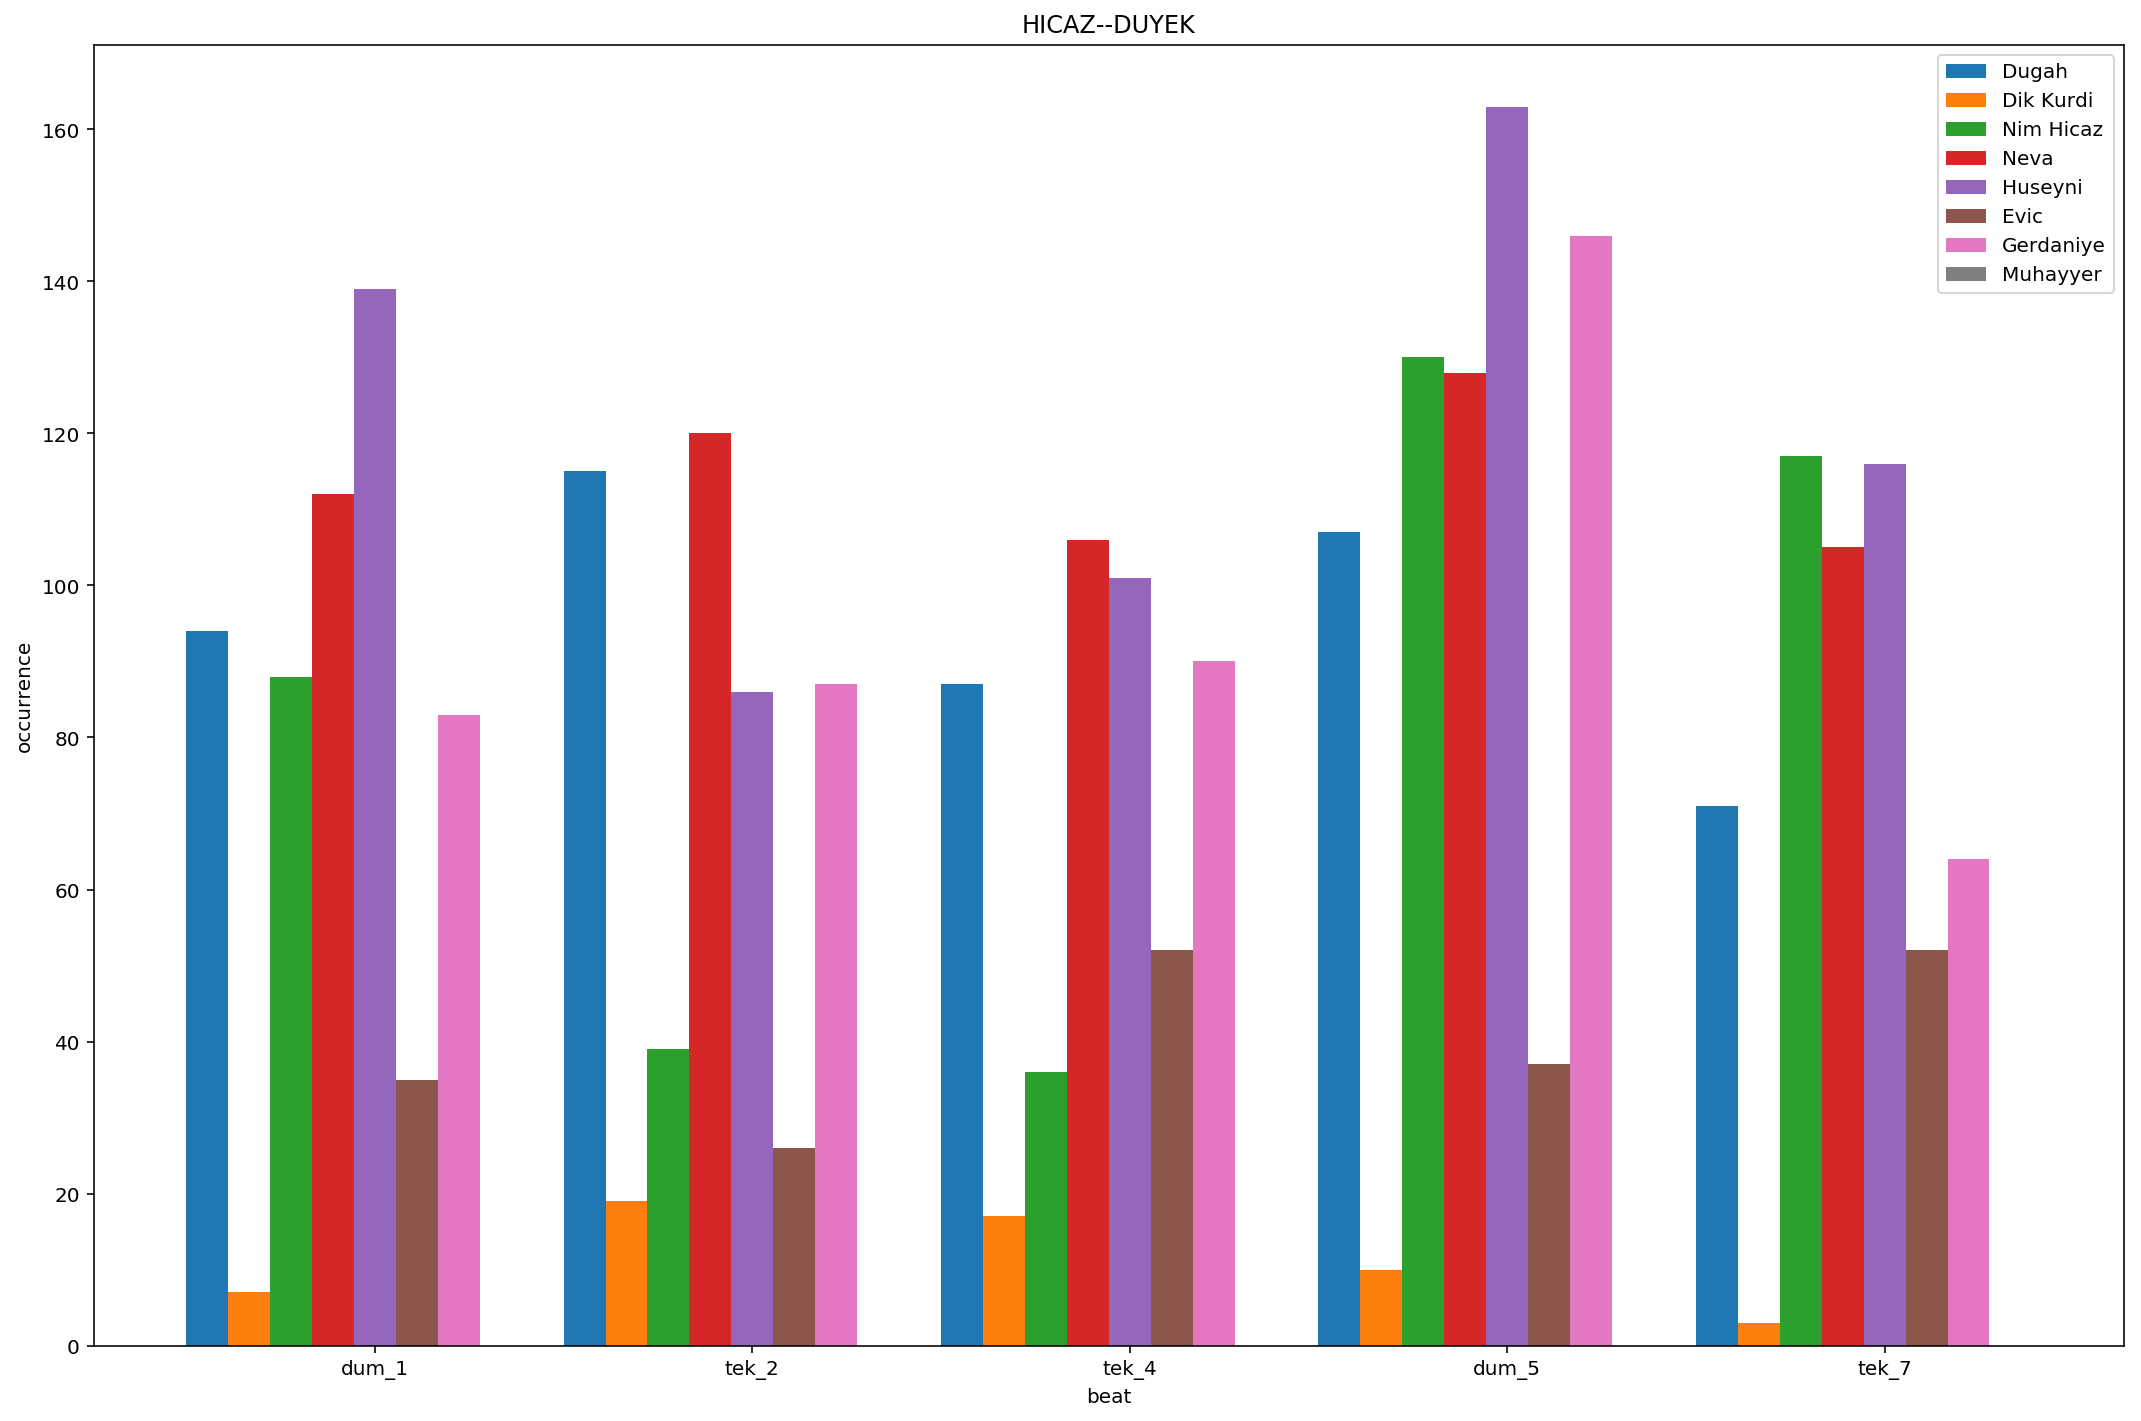

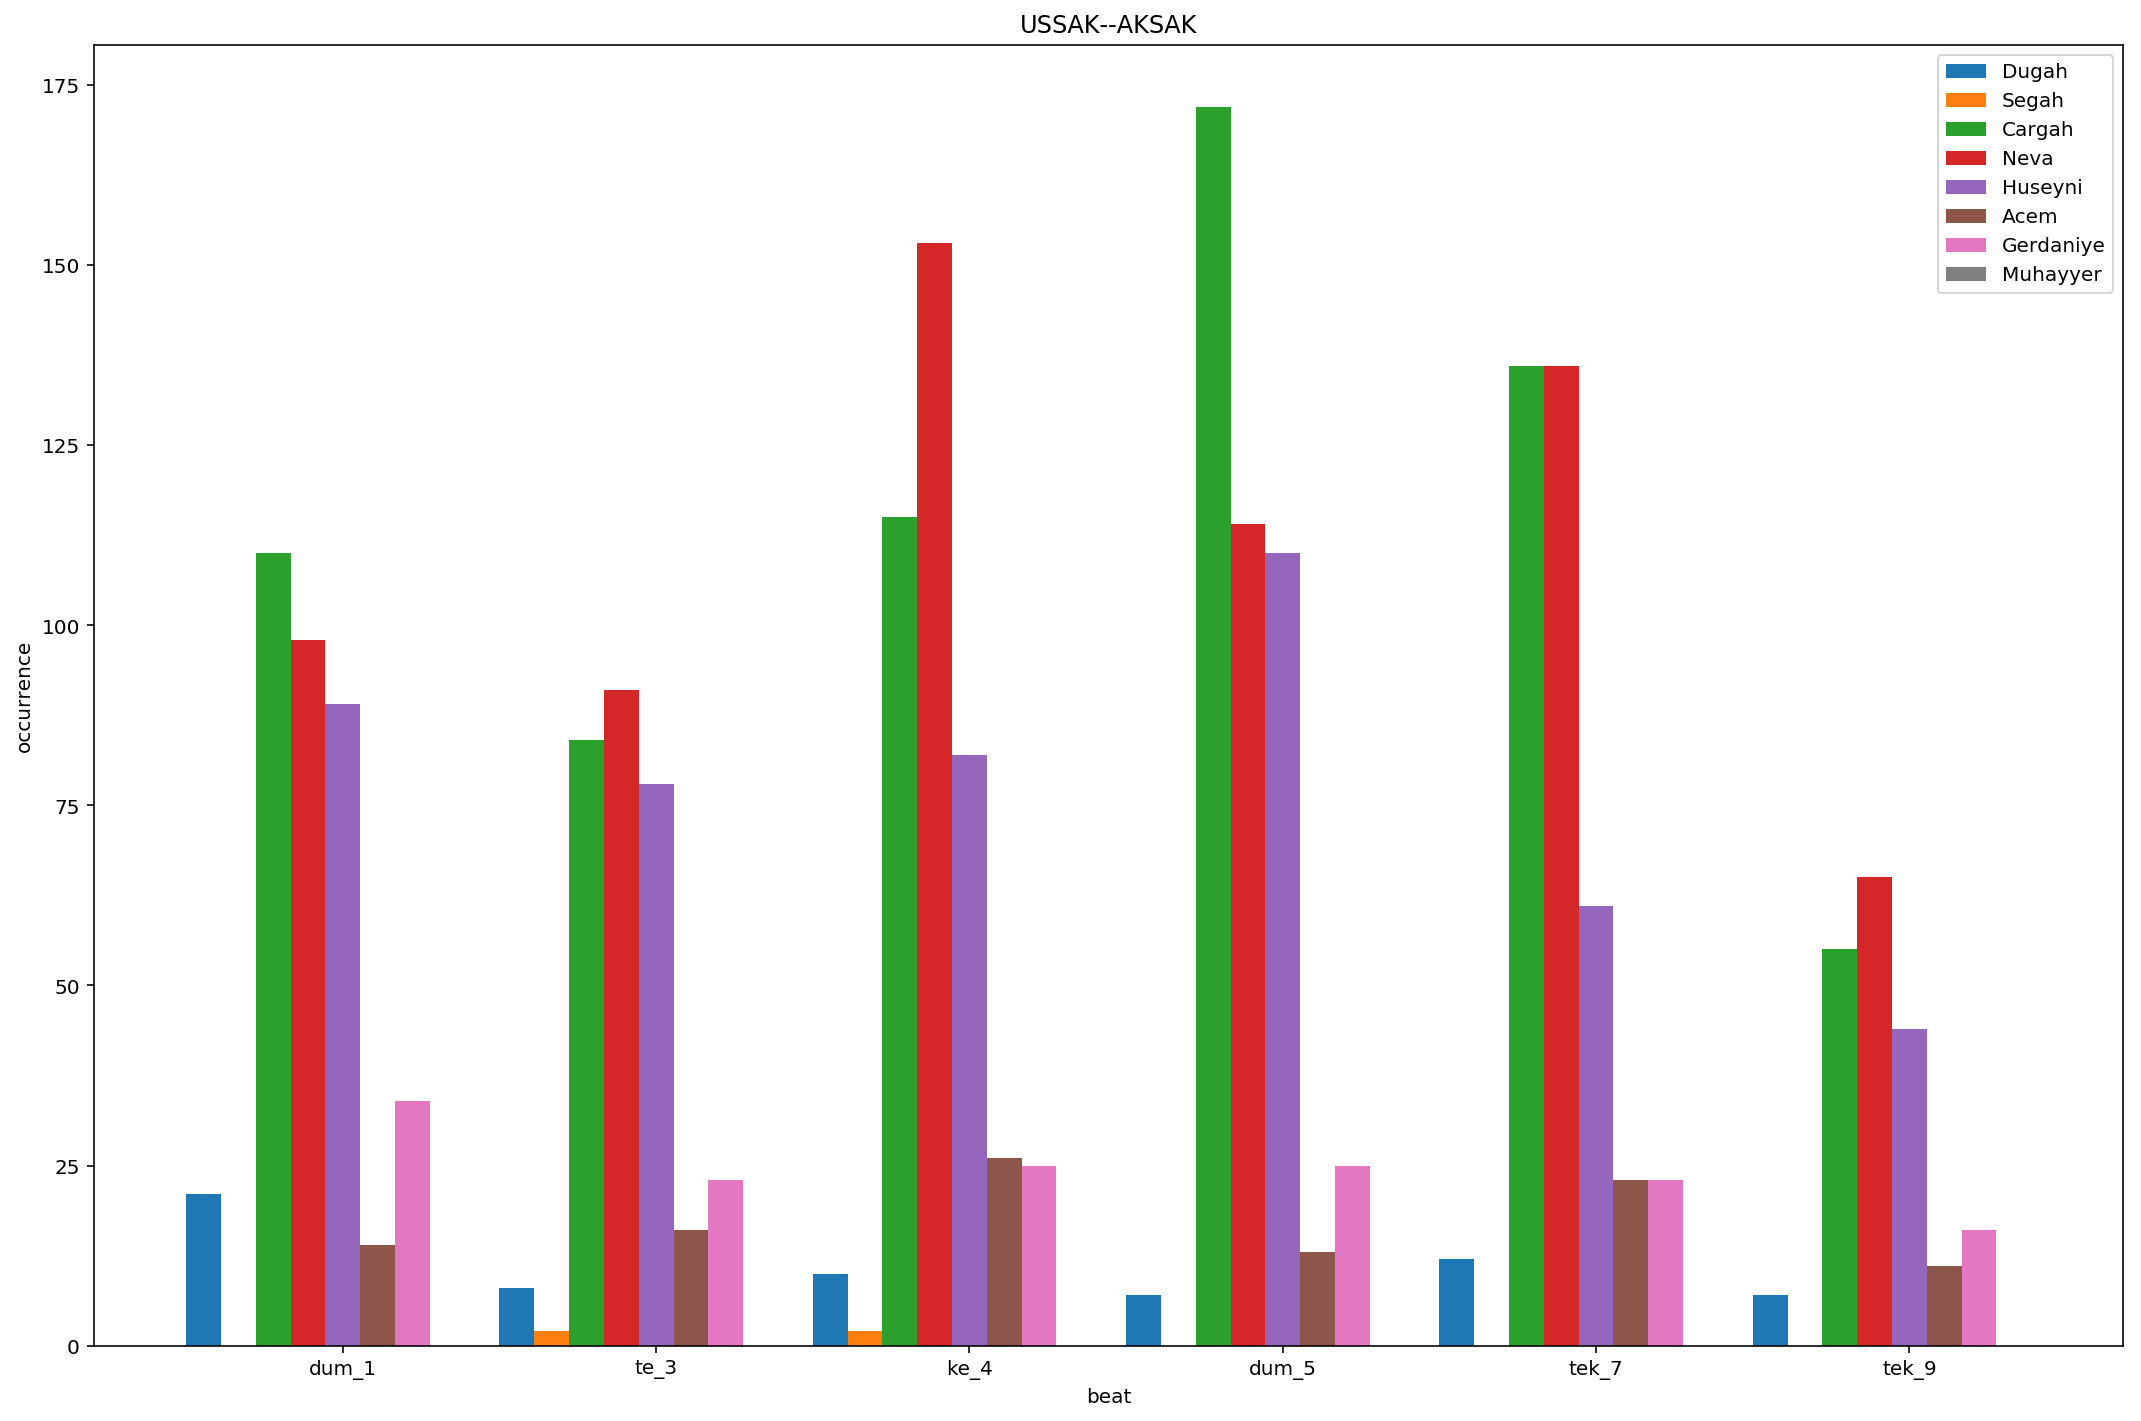

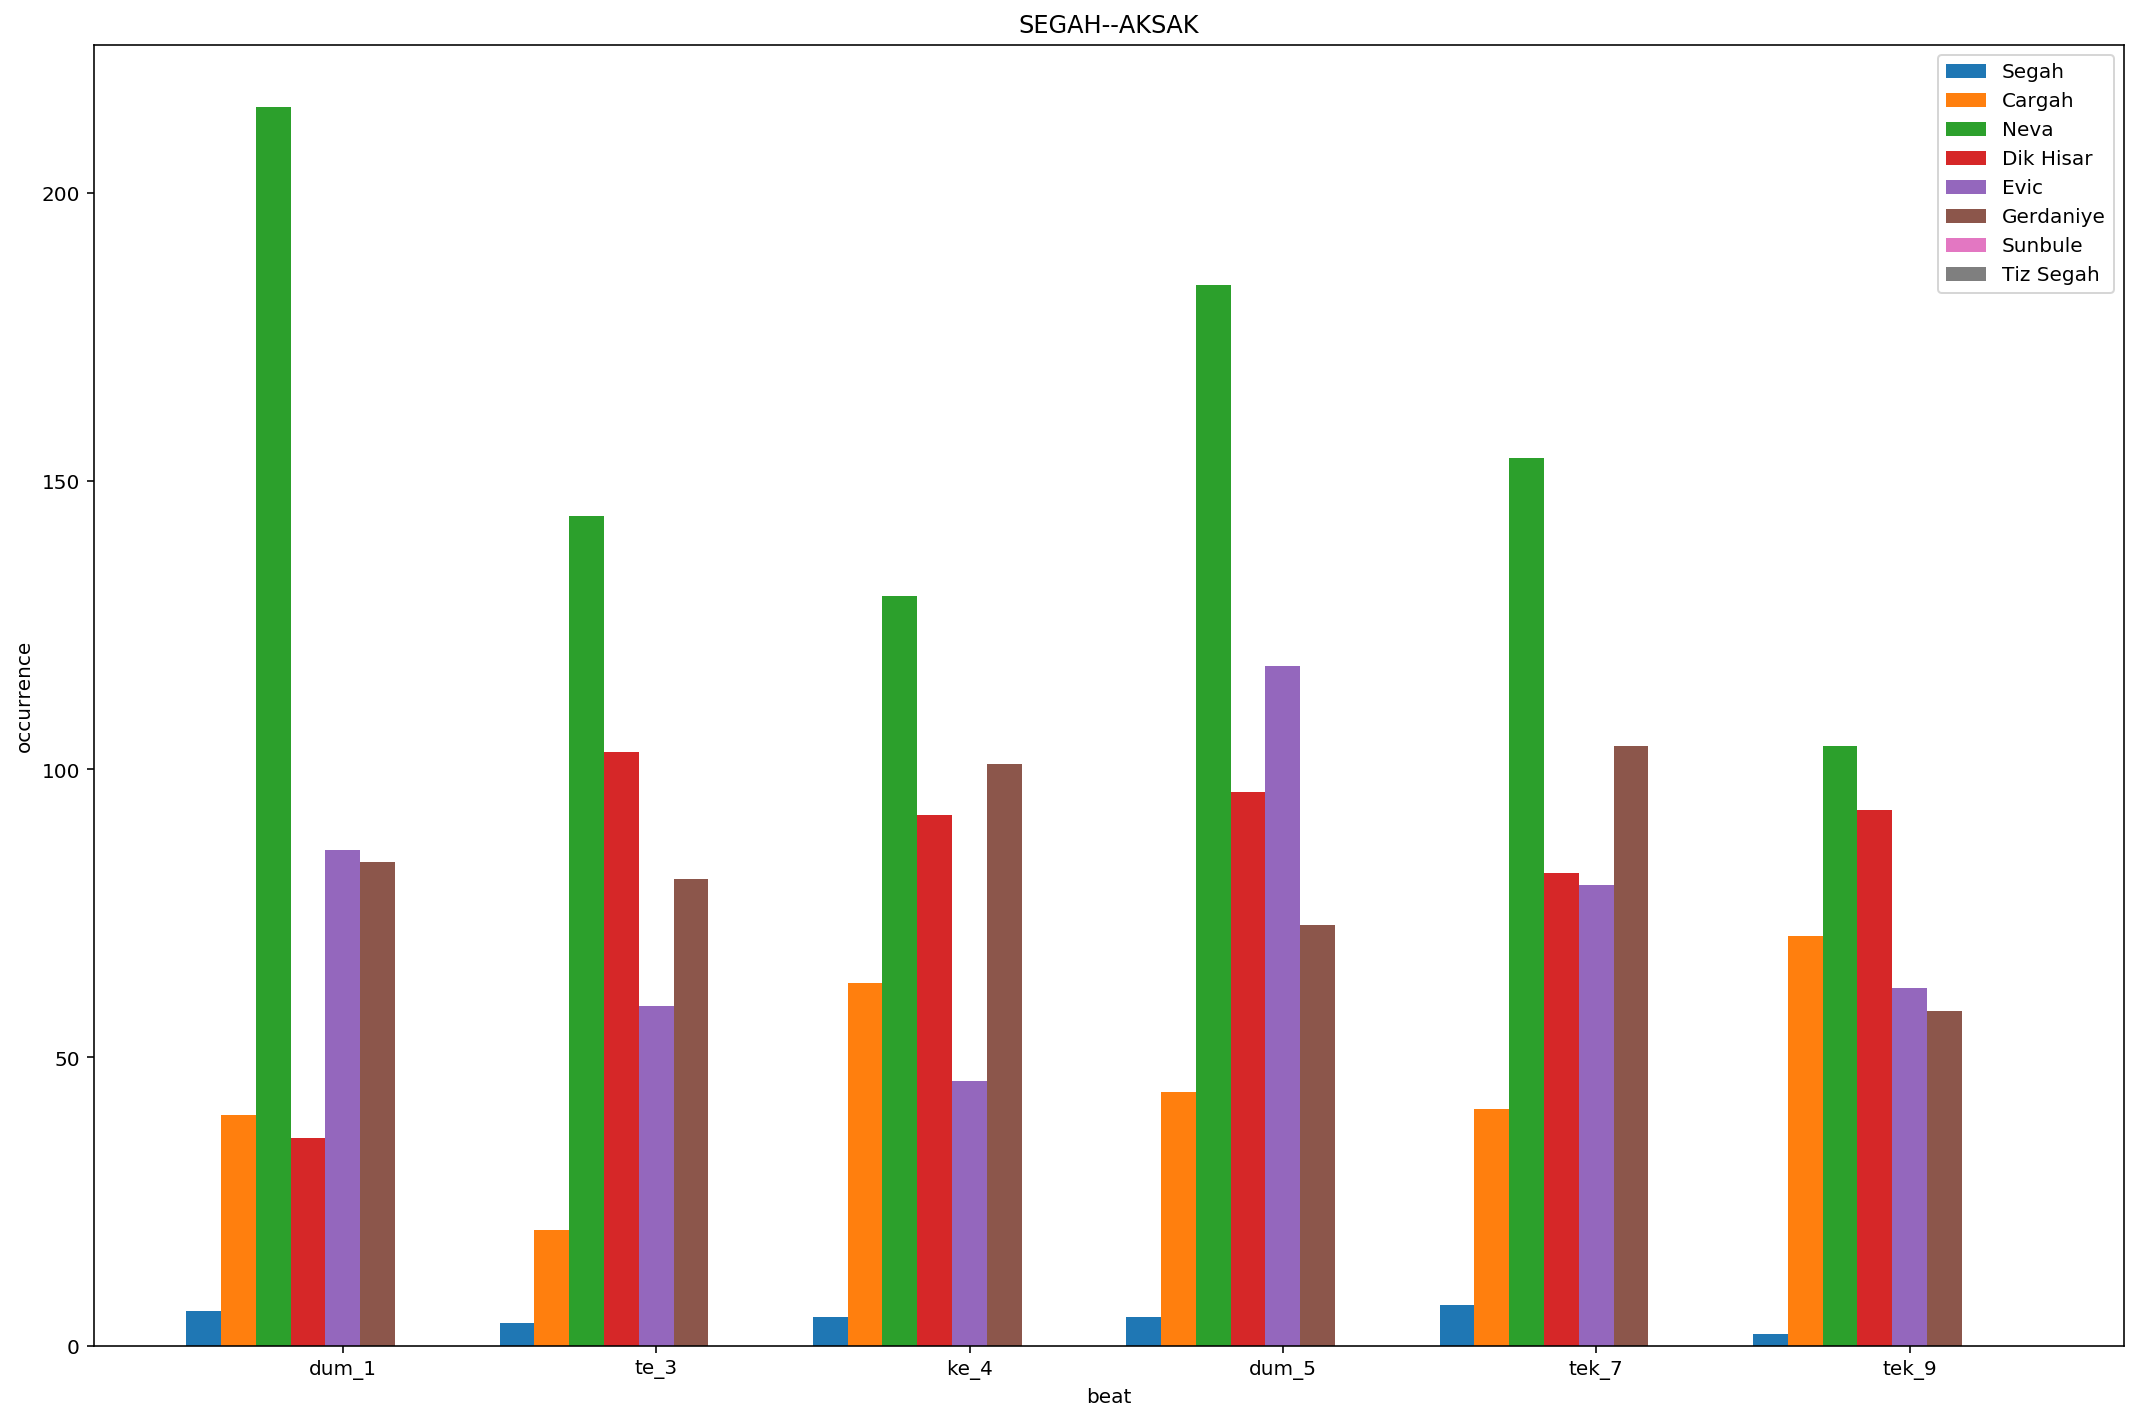

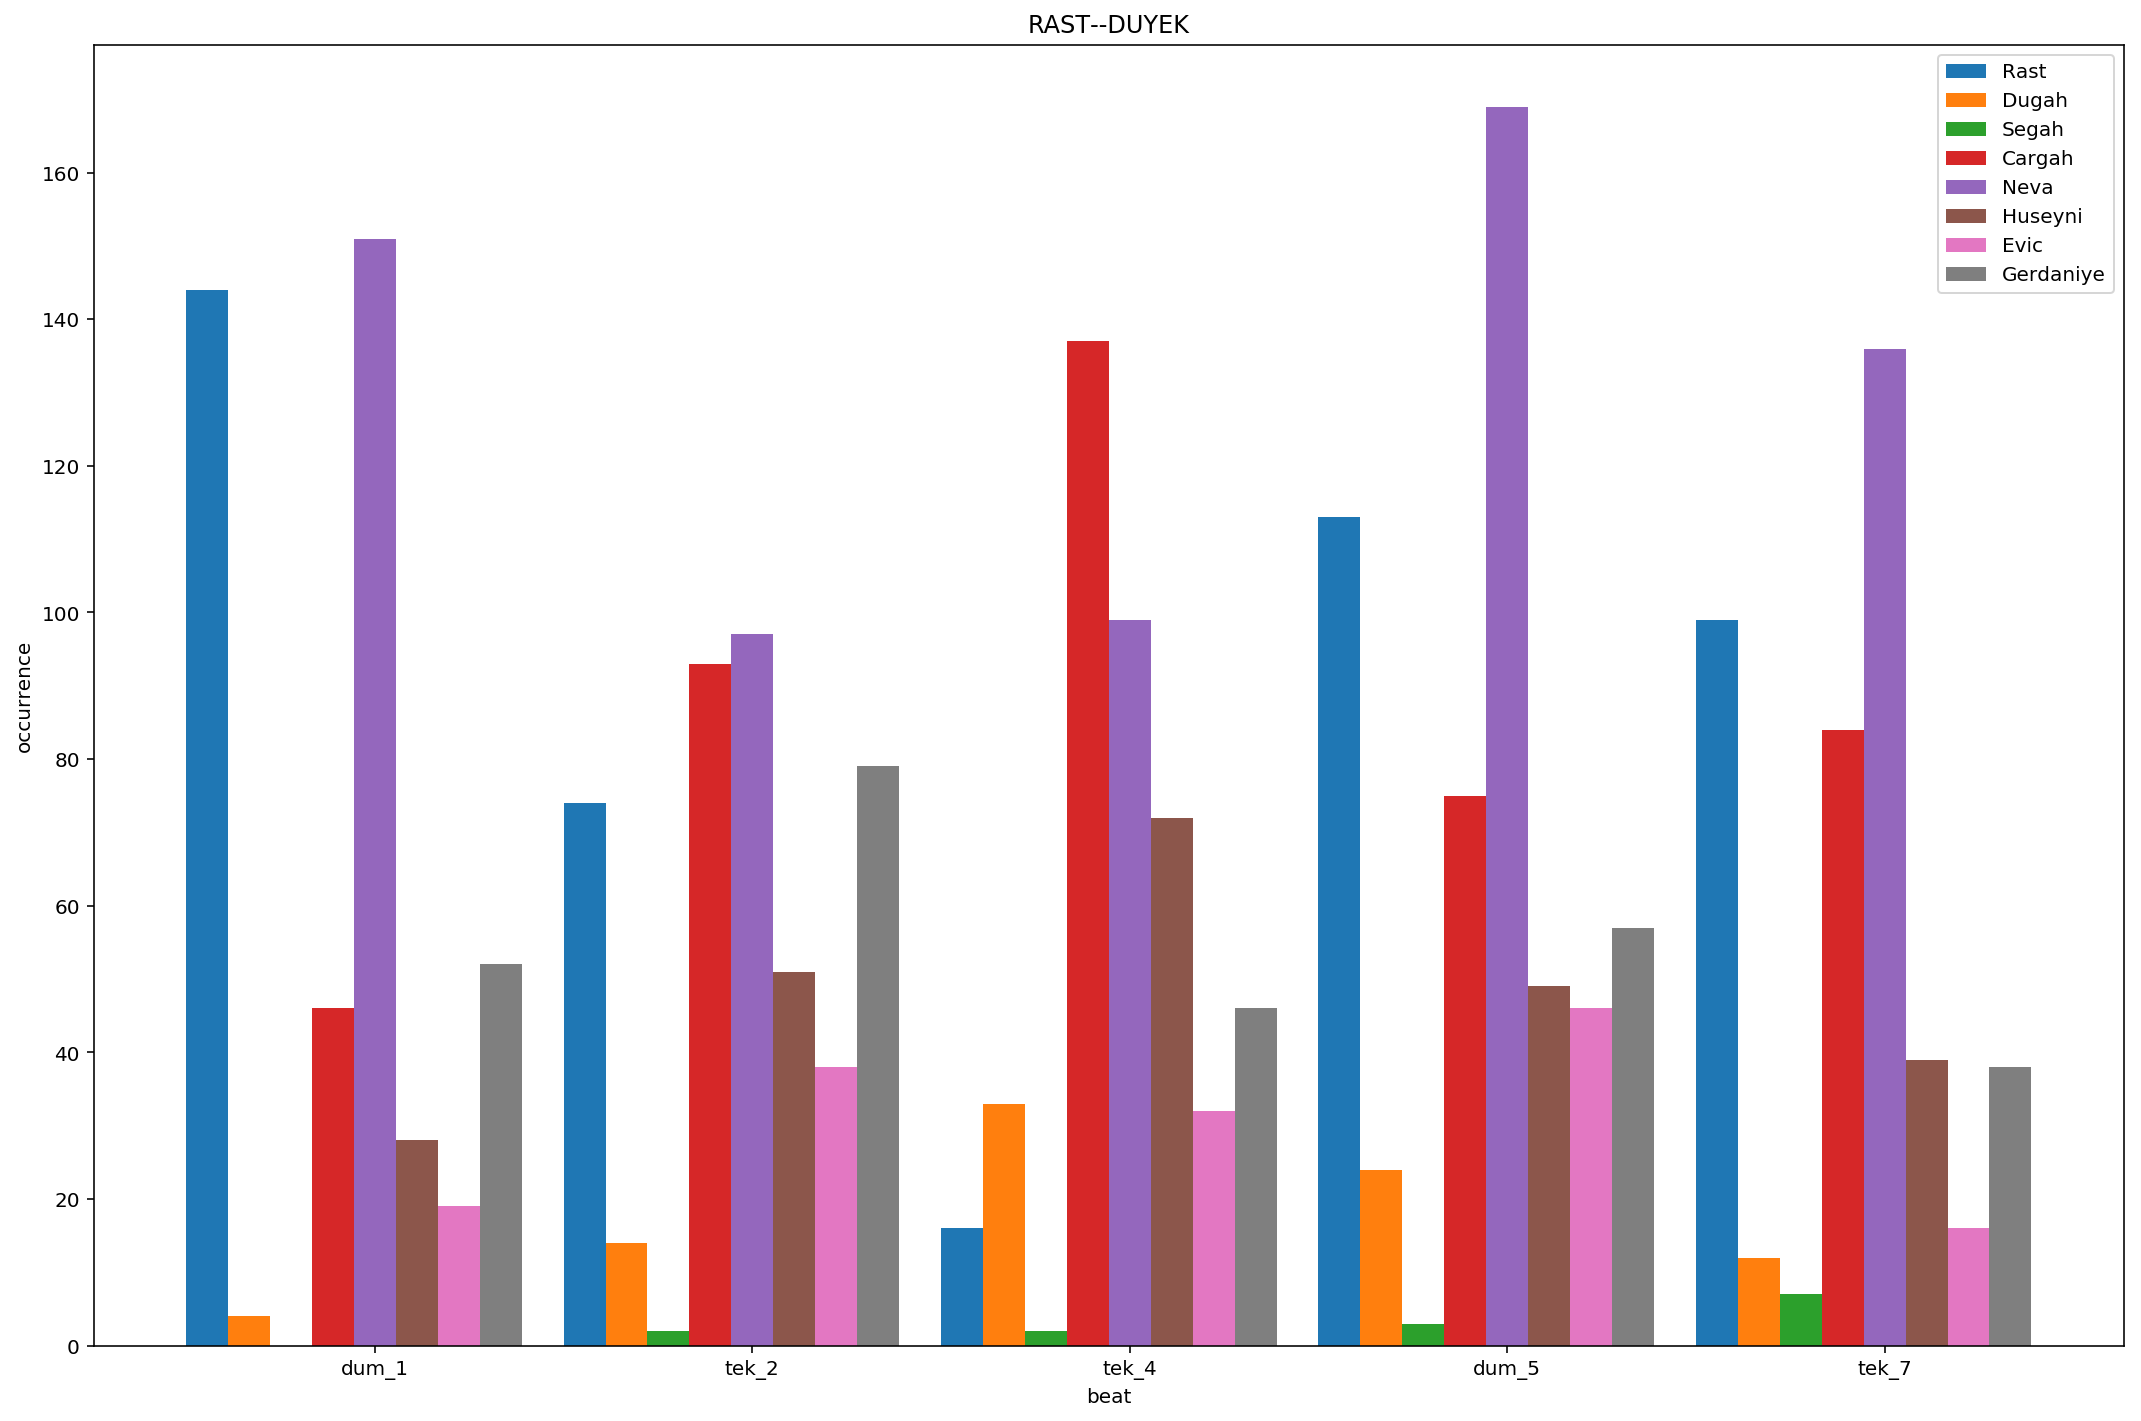

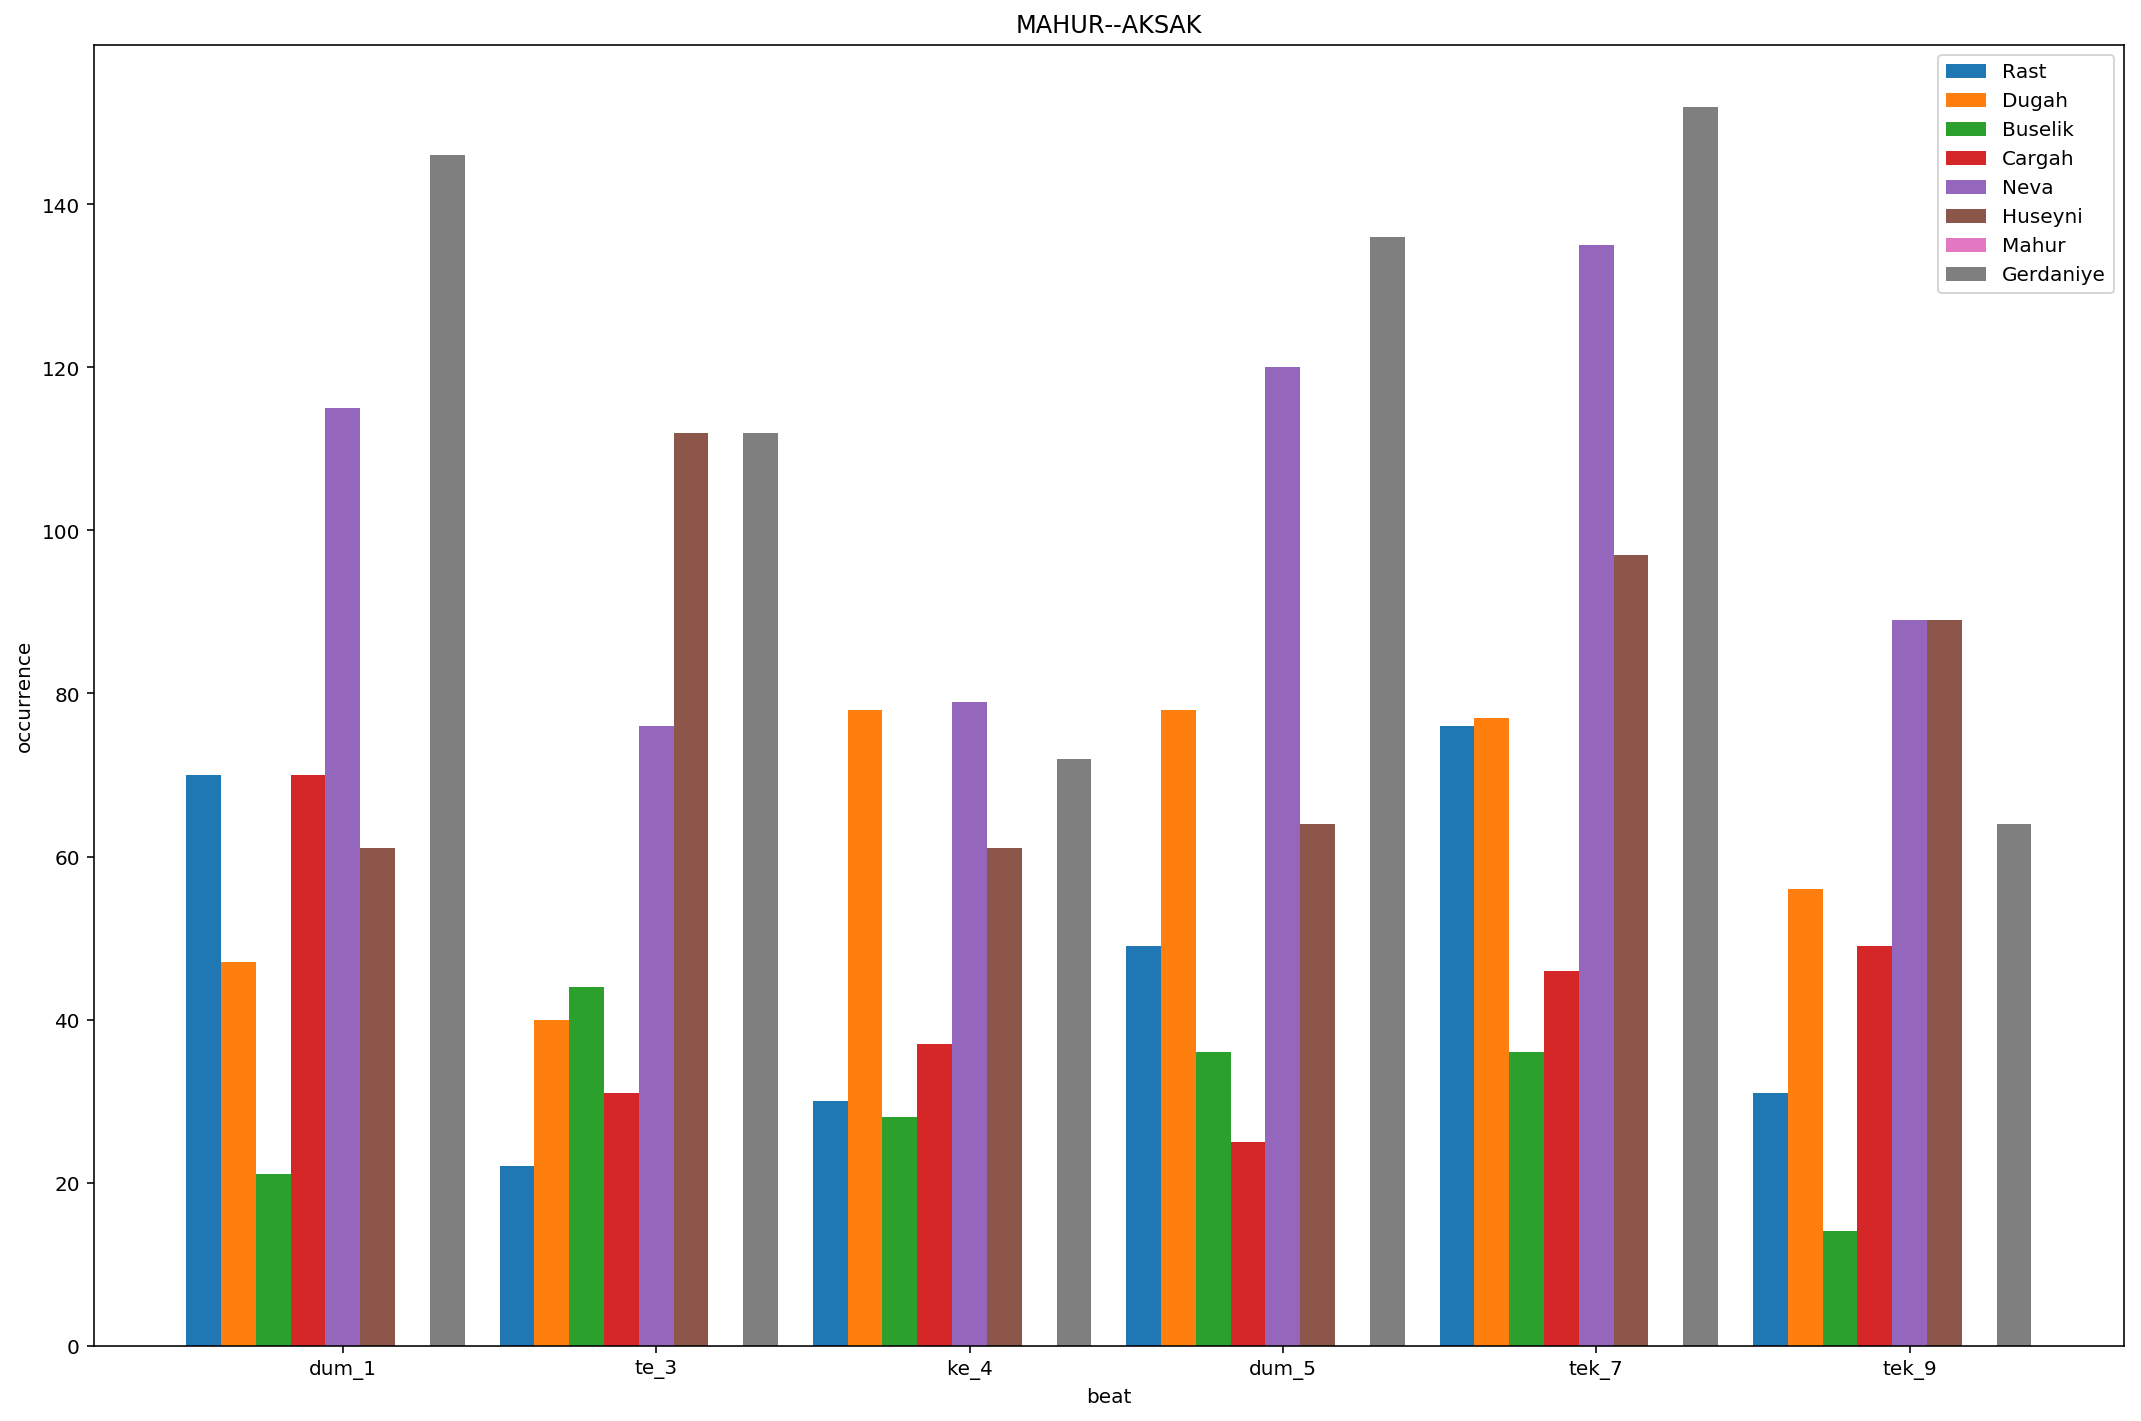

In [8]:
bar_width = 0.35
for mu in mu_top:
    # import ipdb; ipdb.set_trace()
    fig, ax = plt.subplots(figsize = (15,10))
    makam_notes = MAKAM[mu.split('--')[0]]
    usul = USUL[mu.split('--')[1]]
    n_groups = len(usul)
    index = np.arange(n_groups)*bar_width*(1+len(makam_notes))
    beat_name = [a[0]+'_{}'.format(a[1]) for a in usul]
    for note in makam_notes:
        occu = tuple([beat_dict[mu][beat].get(note, 0) for beat in beat_name])
        rects = ax.bar(index, occu, bar_width, label=note)
        index = index + bar_width
    ax.set_xlabel('beat')
    ax.set_ylabel('occurrence')
    ax.set_title(mu.upper())
    ax.set_xticks( np.arange(n_groups)*bar_width*(1+len(makam_notes)) + bar_width*(len(makam_notes))/2)
    ax.set_xticklabels(tuple(beat_name))
    ax.legend()
    fig.tight_layout()
    plt.savefig('./generated_histograms/'+mu+'.png', format = 'png')
    plt.show()

### IMPORTANT:

Analyzing this results, we found suspicious that in some cases the important notes are not appearing on the dictionaries, the most obvious example is happening with the mahur makam, in which the "mahur" note is never retrieved while being the note that "name" the makam. The notebook "mahurIssue" expose this issue better. Also, the same experiment is done using text files annotations and the results were much more reliable.